In [1]:
# import necessary module
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import seaborn as sns
import scipy
from array_response import *
import itertools 

from IPython.display import Image
from matplotlib.gridspec import GridSpec



### Parameters declaration

Declare parameters needed for channel realization

In [2]:
Ns = 5 # number of streams

Nc = 6 # number of cluster
Nray = 5 # number of rays in each cluster

Nt = 64 # number of transmit antennas
Nr = 16 # number of receive antennas

angle_sigma = 10/180*np.pi # standard deviation of the angles in azimuth and elevation both of Rx and Tx

gamma = np.sqrt((Nt*Nr)/(Nc*Nray))
realization = 1000 # equivalent to number of taking sample
count = 0

eps = 0.1 # 20dB isolation
sigma = np.sqrt(8/(1+eps**2)) # according to the normalization condition of H


### Channel Realization

Realize channel H for Dual-Polarized antenna array

In [3]:
H_pol = np.zeros((2*Nr,2*Nt,realization),dtype=complex)
At = np.zeros((Nt,Nc*Nray,realization),dtype=complex)
Ar = np.zeros((Nr,Nc*Nray,realization),dtype=complex)
alpha_hh = np.zeros((Nc*Nray,realization),dtype=complex)
alpha_hv = np.zeros((Nc*Nray,realization),dtype=complex)
alpha_vh = np.zeros((Nc*Nray,realization),dtype=complex)
alpha_vv = np.zeros((Nc*Nray,realization),dtype=complex)
Fopt = np.zeros((2*Nt,Ns,realization),dtype=complex)
Wopt = np.zeros((2*Nr,Ns,realization),dtype=complex)


AoD = np.zeros((2,Nc*Nray),dtype=complex)
AoA = np.zeros((2,Nc*Nray),dtype=complex)

H = np.zeros((2*Nr,2*Nt,realization),dtype=complex)
azi_rot = np.random.uniform(0,2*np.pi,realization)
ele_rot = np.random.uniform(0,np.pi/2,realization) # Why PI/2 ??
R = np.array([[np.cos(ele_rot)*np.cos(azi_rot),np.sin(ele_rot)],[-np.sin(ele_rot)*np.cos(azi_rot),np.cos(ele_rot)]]) # rotation matrix

for reali in range(realization):
    for c in range(1,Nc+1):
        AoD_azi_m = np.random.uniform(0,2*np.pi,1) # Mean Angle of Departure _ azimuth
        AoD_ele_m = np.random.uniform(0,np.pi,1) # Mean Angle of Departure _ elevation
        AoA_azi_m = np.random.uniform(0,2*np.pi,1) # Mean Angle of Arrival_ azimuth
        AoA_ele_m = np.random.uniform(0,np.pi,1) # Mean Angle of Arrival_ elevation
        AoD[0,(c-1)*Nray:Nray*c] = np.random.laplace(AoD_azi_m, angle_sigma, (1,Nray))
        AoD[1,(c-1)*Nray:Nray*c] = np.random.laplace(AoD_ele_m, angle_sigma, (1,Nray))
        AoA[0,(c-1)*Nray:Nray*c] = np.random.laplace(AoA_azi_m, angle_sigma, (1,Nray))
        AoA[1,(c-1)*Nray:Nray*c] = np.random.laplace(AoA_ele_m, angle_sigma, (1,Nray))
    for j in range(Nc*Nray):
        At[:,j,reali] = array_response(AoD[0,j],AoD[1,j],Nt)/np.sqrt(2) # UPA array response
        Ar[:,j,reali] = array_response(AoA[0,j],AoA[1,j],Nr)/np.sqrt(2)
        var_hh = ((sigma**2)*(np.cos(AoD[0,j])**2)*(np.cos(AoA[0,j])**2)).real
        var_hv = ((eps**2)*(sigma**2)*(np.cos(AoD[1,j])**2)*(np.cos(AoA[0,j])**2)).real
        var_vh = ((eps**2)*(sigma**2)*(np.cos(AoD[0,j])**2)*(np.cos(AoA[1,j])**2)).real
        var_vv = ((sigma**2)*(np.cos(AoD[1,j])**2)*(np.cos(AoA[1,j])**2)).real
        alpha_hh[j,reali] = np.random.normal(0, np.sqrt(var_hh/2)) + 1j*np.random.normal(0, np.sqrt(var_hh/2))
        alpha_hv[j,reali] = np.random.normal(0, np.sqrt(var_hv/2)) + 1j*np.random.normal(0, np.sqrt(var_hv/2))
        alpha_vh[j,reali] = np.random.normal(0, np.sqrt(var_vh/2)) + 1j*np.random.normal(0, np.sqrt(var_vh/2))
        alpha_vv[j,reali] = np.random.normal(0, np.sqrt(var_vv/2)) + 1j*np.random.normal(0, np.sqrt(var_vv/2))
        alpha = np.vstack((np.hstack((alpha_hh[j,reali],alpha_hv[j,reali])),np.hstack((alpha_vh[j,reali],alpha_vv[j,reali]))))
        H_pol[:,:,reali] = H_pol[:,:,reali] + np.kron(alpha,Ar[:,[j],reali]@At[:,[j],reali].conj().T)
    H_pol[:,:,reali] = 2*gamma* H_pol[:,:,reali]
    H[:,:,reali] = (np.kron(R[:,:,reali],np.eye(Nr)))@H_pol[:,:,reali]
    H[:,:,reali] = np.sqrt(4/3)* H[:,:,reali]
    
    if (np.linalg.matrix_rank(H[:,:,reali])>=Ns):
        U, s, V = np.linalg.svd(H[:,:,reali], full_matrices=True)
        V = V.conj().T
        Fopt[:,:,reali] = V[0:2*Nt,0:Ns]
        Wopt[:,:,reali] = U[0:2*Nr,0:Ns]

### Check normalized condition

In [4]:
channel_fro_1 = np.zeros(realization)
for reali in range(realization):
    channel_fro_1[reali] = np.linalg.norm(H_pol[:,:,reali],'fro')
print("4*Nt*Nr =", 4*Nt*Nr , "   Frobenius norm H pol=", np.mean(channel_fro_1**2))

4*Nt*Nr = 4096    Frobenius norm H pol= 4077.2328517001365


In [5]:
channel_fro_2 = np.zeros(realization)
for reali in range(realization):
    channel_fro_2[reali] = np.linalg.norm(H[:,:,reali],'fro')
print("4*Nt*Nr =", 4*Nt*Nr , "   Frobenius norm =", np.mean(channel_fro_2**2))

4*Nt*Nr = 4096    Frobenius norm = 4078.4450591177324


### OMP

In [6]:
def OMP_dual(_Fopt,_NRF,_At):
    _FRF = np.empty((2*_At.shape[0],0))
    _Fres = _Fopt
#     Nt = int(Fopt.shape[0]/2)
    Nt = int(_At[:,:].shape[0])
    for k in range(_NRF):
        PU_h = _At.conj().T@_Fres[0:Nt,:]
        ind_h = np.argmax(np.sum((np.absolute(PU_h))**2,axis=1))
        PU_v = _At.conj().T@_Fres[Nt:2*Nt,:]
        ind_v = np.argmax(np.sum((np.absolute(PU_v))**2,axis=1))
        _FRF = np.append(_FRF,np.vstack((_At[:,[ind_h]],_At[:,[ind_v]])) ,axis=1)
        _FBB = (np.linalg.pinv(_FRF))@_Fopt
        _Fres = (_Fopt-_FRF@_FBB)/np.linalg.norm((_Fopt-_FRF@_FBB),'fro')
#         _Fres = (_Fopt-_FRF@_FBB)
    return _FRF,_FBB

In [7]:
int(At[:,:].shape[0])

64

### Plot Spectral Efficiency with Precoder and Combiner getting from OMP

In [8]:
NRF = 10
SNR_dB = np.arange(-35,10,5)
SNR = 10**(SNR_dB/10)
smax = SNR.shape[0]
R = np.zeros([smax, realization],dtype=complex)
R_o = np.zeros([smax, realization],dtype=complex)

for reali in range(realization):
    FRF, FBB = OMP_dual( Fopt[:,:,reali], NRF, At[:,:,reali])
    FBB = np.sqrt(Ns)*FBB/np.linalg.norm(FRF@FBB,'fro')
    WRF, WBB = OMP_dual( Wopt[:,:,reali], NRF, Ar[:,:,reali])
    WBB = np.sqrt(Ns)*WBB/np.linalg.norm(WRF@WBB,'fro')
    
    for s in range(smax):
        R[s,reali] = np.log2(np.linalg.det(np.eye(Ns)+SNR[s]/Ns*np.linalg.pinv(WRF@WBB)@H[:,:,reali]@FRF@FBB@FBB.conj().T@FRF.conj().T@H[:,:,reali].conj().T@WRF@WBB))
        R_o[s,reali] = np.log2(np.linalg.det(np.eye(Ns)+SNR[s]/Ns*np.linalg.pinv(Wopt[:,:,reali])@H[:,:,reali]@Fopt[:,:,reali]@Fopt[:,:,reali].conj().T@H[:,:,reali].conj().T@Wopt[:,:,reali]))


In [23]:
Fopt.shape

(128, 5, 1000)

In [26]:
x = np.linalg.norm(FRF@FBB,'fro')
print("Ns", Ns , "   Frobenius norm FRF*FBB=", x**2)

Ns 5    Frobenius norm FRF*FBB= 5.000000000000003


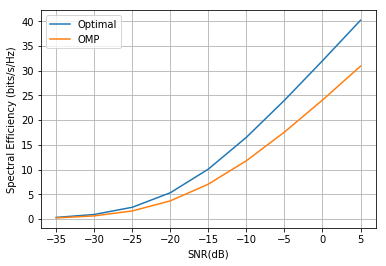

In [10]:
# plt.plot(SNR_dB, (np.sum(R,axis=1).real)/realization, label='OMP')
plt.plot(SNR_dB, (np.sum(R_o,axis=1).real)/realization, label='Optimal')
plt.plot(SNR_dB, (np.sum(R,axis=1).real)/realization, label='OMP')

plt.legend(loc='upper left')
plt.xlabel('SNR(dB)')
plt.ylabel('Spectral Efficiency (bits/s/Hz)')
plt.grid()
plt.show()

### Joint Horizontal/Vertical Beamformer Selection

| hori_tx | hori_rx | verti_tx | verti_rx |
|:--------|--------|--------:|:---------:|

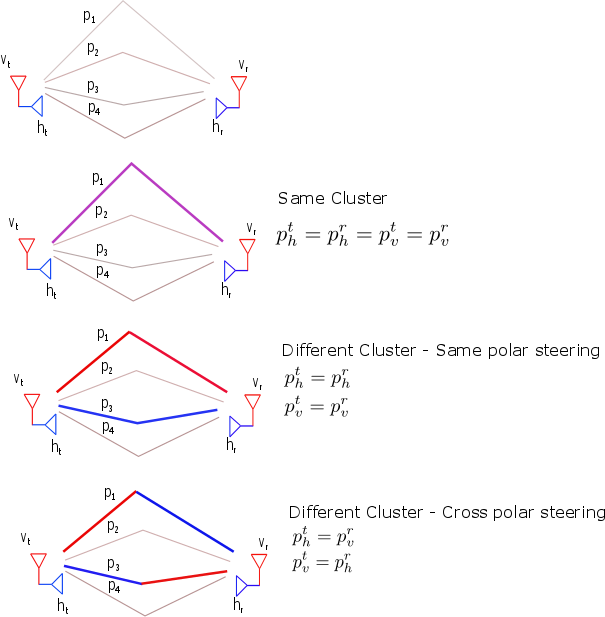

In [11]:
Image("img/cluster.png")

### Histogram of chosen path

__path gain of each combination__

Numpath = number of total combination

path_combi = arrangement of combination

In [12]:
total_combi = Nc*Nray
cluster = np.arange(total_combi)
print(cluster)
c = list(itertools.combinations(cluster, 2))
num_path = (2*total_combi-1)*total_combi
path_combi = np.zeros((num_path,4),dtype=int)

print(path_combi.shape)
path_combi[0:total_combi,:]=np.arange(total_combi).reshape(total_combi,1).repeat(4,axis=1)

count = 0
for i in range(int(total_combi*(total_combi-1)/2)):
    path_combi[total_combi+4*i,:] = np.array([c[count][0],c[count][0],c[count][1],c[count][1]])
    path_combi[total_combi+4*i+1,:] = np.array([c[count][1],c[count][1],c[count][0],c[count][0]])
    path_combi[total_combi+4*i+2,:] = np.array([c[count][0],c[count][1],c[count][1],c[count][0]])
    path_combi[total_combi+4*i+3,:] = np.array([c[count][1],c[count][0],c[count][0],c[count][1]])
    count = count+1
# print(path_combi[0:10,:])
path_gain = np.zeros((num_path,realization)) # 2 to save the position and maximum value
for reali in range(realization):
    for combi in range(num_path):
        path_gain[combi,reali] =\
        (np.abs\
         ((np.cos(ele_rot[reali])*np.cos(azi_rot[reali])*alpha_hh[path_combi[combi,0],reali]+np.sin(ele_rot[reali])*alpha_vh[path_combi[combi,0],reali])*(path_combi[combi,0]==path_combi[combi,1])+\
         (np.cos(ele_rot[reali])*np.cos(azi_rot[reali])*alpha_hv[path_combi[combi,2],reali]+np.sin(ele_rot[reali])*alpha_vv[path_combi[combi,2],reali])*(path_combi[combi,2]==path_combi[combi,1])+\
         (-np.sin(ele_rot[reali])*np.cos(azi_rot[reali])*alpha_hh[path_combi[combi,0],reali]+np.cos(ele_rot[reali])*alpha_vh[path_combi[combi,0],reali])*(path_combi[combi,0]==path_combi[combi,3])+\
         (-np.sin(ele_rot[reali])*np.cos(azi_rot[reali])*alpha_hv[path_combi[combi,2],reali]+np.cos(ele_rot[reali])*alpha_vv[path_combi[combi,2],reali])*(path_combi[combi,2]==path_combi[combi,3])
         ))**2


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
(1770, 4)


In [13]:
print(num_path)
print(path_gain.shape)
print(alpha_hh.shape)

1770
(1770, 1000)
(30, 1000)


__Check maximum gain from combination of path in each realization__

To do the joint polar beam steering later

In [14]:
index = np.zeros(realization,dtype=int)
for reali in range(realization):
    index[reali] = np.argmax(path_gain[:,reali])

sort_path_gain = np.zeros([num_path,realization])
sort_path_gain = np.argsort(path_gain,axis=0)

In [15]:
print(path_gain[:,0])
print(sort_path_gain[:,0])
print(sort_path_gain[-3,0])
print(path_combi[2])
print(Ns)

[ 0.01415204 12.32593159  0.18863584 ...  0.04197879  0.02063302
  0.34582246]
[1610 1712 1726 ... 1117  292   11]
1117
[2 2 2 2]
5


In [31]:
print(sort_path_gain[:,0])
_chosen_combi_path = np.zeros([Ns,4],dtype=int)
_chosen_combi_path[0] = path_combi[sort_path_gain[-1,0]]
print(path_combi[sort_path_gain[-1,0]])
count = 1
index = 1

while count<Ns:
    score = 0
    print(index)
    for i in range(count):
        print(path_combi[sort_path_gain[-1-index,0]])
        print(path_combi[sort_path_gain[-1-i,0]])
        if sum(path_combi[sort_path_gain[-1-index,0]] == path_combi[sort_path_gain[-1-i,0]])>0:
            score += 1
    if score == 0:
        _chosen_combi_path[count] = path_combi[sort_path_gain[-1-index,0]]
        count += 1
        print('yes')
    else:
        print('no')
    index += 1
print(_chosen_combi_path)

[1610 1712 1726 ... 1117  292   11]
[11 11 11 11]
1
[ 2 11 11  2]
[11 11 11 11]
no
2
[19 11 11 19]
[11 11 11 11]
no
3
[ 5 11 11  5]
[11 11 11 11]
no
4
[26 11 11 26]
[11 11 11 11]
no
5
[29 11 11 29]
[11 11 11 11]
no
6
[14 11 11 14]
[11 11 11 11]
no
7
[27 11 11 27]
[11 11 11 11]
no
8
[28 11 11 28]
[11 11 11 11]
no
9
[25 11 11 25]
[11 11 11 11]
no
10
[ 6 11 11  6]
[11 11 11 11]
no
11
[15 11 11 15]
[11 11 11 11]
no
12
[18 11 11 18]
[11 11 11 11]
no
13
[23 11 11 23]
[11 11 11 11]
no
14
[20 11 11 20]
[11 11 11 11]
no
15
[ 0 11 11  0]
[11 11 11 11]
no
16
[17 11 11 17]
[11 11 11 11]
no
17
[ 1 11 11  1]
[11 11 11 11]
no
18
[24 11 11 24]
[11 11 11 11]
no
19
[ 9 11 11  9]
[11 11 11 11]
no
20
[12 11 11 12]
[11 11 11 11]
no
21
[16 11 11 16]
[11 11 11 11]
no
22
[ 3 11 11  3]
[11 11 11 11]
no
23
[ 4 11 11  4]
[11 11 11 11]
no
24
[21 11 11 21]
[11 11 11 11]
no
25
[22 11 11 22]
[11 11 11 11]
no
26
[10 11 11 10]
[11 11 11 11]
no
27
[13 11 11 13]
[11 11 11 11]
no
28
[ 7 11 11  7]
[11 11 11 11]
no
29
[ 2 

In [17]:
print(_chosen_combi_path)

[[11 11 11 11]
 [ 2 10 10  2]
 [19 10 10 19]
 [ 1  1  1  1]
 [10 10 10 10]]


In [18]:
SNR_dB = np.arange(-35,10,5)
SNR = 10**(SNR_dB/10)
smax = SNR.shape[0]
R_cross = np.zeros([smax, realization],dtype=complex)


for reali in range(realization):
    _chosen_combi_path = np.zeros([Ns,4],dtype=int)
    _chosen_combi_path[0] = path_combi[sort_path_gain[-1,reali]]
    count = 1
    index = 1
    while count<Ns:
        score = 0
        for i in range(count):
            if sum(path_combi[sort_path_gain[-1-index,reali]] == path_combi[sort_path_gain[-1-i,reali]])>0:
                score += 1
        if score == 0:
            _chosen_combi_path[count] = path_combi[sort_path_gain[-1-index,0]]
            count += 1
        index += 1
        
    W_cross = np.vstack((Ar[:,[_chosen_combi_path[0,1]],reali],Ar[:,[_chosen_combi_path[0,3]],reali]))
    F_cross = np.vstack((At[:,[_chosen_combi_path[0,0]],reali],At[:,[_chosen_combi_path[0,2]],reali]))
    for i in range(Ns-1):
        W_cross = np.hstack((W_cross,np.vstack((Ar[:,[_chosen_combi_path[i+1,1]],reali],Ar[:,[_chosen_combi_path[i+1,3]],reali]))))
        F_cross = np.hstack((F_cross,np.vstack((At[:,[_chosen_combi_path[i+1,0]],reali],At[:,[_chosen_combi_path[i+1,2]],reali]))))
        
    FBB_cross = np.sqrt(Ns)*np.eye(Ns)/np.linalg.norm(F_cross@np.eye(Ns),'fro')
    WBB_cross = np.sqrt(Ns)*np.eye(Ns)/np.linalg.norm(W_cross@np.eye(Ns),'fro')
    for s in range(smax):
        R_cross[s,reali] = np.log2(np.linalg.det(np.eye(Ns)+(SNR[s]/Ns)*np.linalg.pinv(W_cross@WBB_cross)@H[:,:,reali]@F_cross@FBB_cross@FBB_cross.conj().T@F_cross.conj().T@H[:,:,reali].conj().T@W_cross@WBB_cross))

In [28]:
_chosen_combi_path

array([[22,  2,  2, 22],
       [ 2, 11, 11,  2],
       [19, 11, 11, 19],
       [26, 11, 11, 26],
       [17, 10, 10, 17]])

In [30]:
path_gain.shape

(1770, 1000)

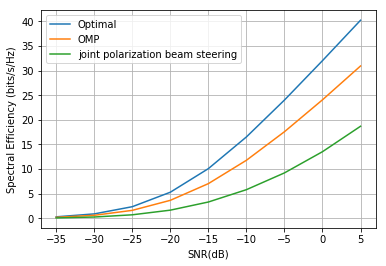

In [19]:
# plt.plot(SNR_dB, (np.sum(R,axis=1).real)/realization, label='OMP')
plt.plot(SNR_dB, (np.sum(R_o,axis=1).real)/realization, label='Optimal')
plt.plot(SNR_dB, (np.sum(R,axis=1).real)/realization, label='OMP')
plt.plot(SNR_dB, (np.sum(R_cross,axis=1).real)/realization, label='joint polarization beam steering')

plt.legend(loc='upper left')
plt.xlabel('SNR(dB)')
plt.ylabel('Spectral Efficiency (bits/s/Hz)')
plt.grid()
plt.show()

In [20]:
FBB_cross = np.sqrt(Ns)*np.eye(Ns)/np.linalg.norm(F_cross@np.eye(Ns),'fro')

In [21]:
x = np.linalg.norm(F_cross@FBB_cross,'fro')
print("Ns", Ns , "   Frobenius norm FRF*FBB=", x**2)

Ns 5    Frobenius norm FRF*FBB= 5.000000000000001
